# Comparing weather conditions between Madrid and New York City

Both Madrid and New York are on the same latitude (40 degrees) so I thought it would be funny to compare if the weather conditions are similar (hint [they are not, because of the Gulf Stream](https://www.livescience.com/13573-east-coast-colder-europe-west-coast.html)).

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
import re
import requests

# Some chart-draw functions

In [4]:
def add_day_of_year_to_df(city_df, year_range=None):
    """
    Add DayOfYear, Year and LeapDay to our city weather dataframe.
    Returns a copy of that extended datafram.
    """
    
    def day_of_year(date_string):
        return re.sub(r"^\d{4}\-", "", date_string)

    extended_city_df = city_df.copy()
    
    extended_city_df["DayOfYear"] = extended_city_df["Date"].map(day_of_year)
    extended_city_df["Year"] = extended_city_df["Date"].map(lambda date_i: int(date_i.split("-")[0]))
    extended_city_df["LeapDay"] = extended_city_df["DayOfYear"].map(lambda day_of_year_i: day_of_year_i == "02-29")
    
    # Drop leap days
    extended_city_df.drop(extended_city_df[extended_city_df["LeapDay"]].index, inplace=True)
    
    return extended_city_df


In [5]:
def select_years_of_df(city_df, year_range):
    """
    Given a city weather dataframe and a year range, select the data that is inside the year range
    """
    
    if not year_range:
        first_year = city_df["Date"].min().split('-')[0]
        last_year = city_df["Date"].max().split('-')[0]
        year_range = (first_year, last_year)
    
    start_year = year_range[0]
    start_date = "{}-01-01".format(start_year)
    end_year = year_range[1]
    end_date = "{}-12-31".format(end_year)
    return city_df[(city_df.Date >= start_date) & (city_df.Date <= end_date)].sort_values(["Date"], ascending=[1])


In [177]:
def plot_magnitude_by_day_of_year(city_df, city, magnitude, magnitude_human_name, value_type=["max", "min"], rolling_window=None, year_range=None, ax=None):
    """
    Plot magnitude by day of year for a city
    """
    
    magnitude_df = add_day_of_year_to_df(city_df)
    
    magnitude_df = select_years_of_df(magnitude_df, year_range=year_range)
    
    magnitude_by_day_df = magnitude_df.groupby("DayOfYear")
    days_of_year = magnitude_df["DayOfYear"].drop_duplicates()
    days_of_year_range = range(0, len(days_of_year))
      
    if ax is None:
        ax = plt.gca()

    if len(value_type) == 1:
        legend_locs = ["upper right"]
    elif len(value_type) == 2:
        legend_locs = ["upper right", "upper left"]
    elif len(value_type) == 3:
        legend_locs = ["upper right", "upper left", "upper center"]
        
    # Magnitude value for each day
    if "ad-hoc" in value_type:
        magnitude_column = "{}".format(magnitude)
        max_values = magnitude_by_day_df[magnitude_column].max()
        mean_values = magnitude_by_day_df[magnitude_column].mean()
        min_values = magnitude_by_day_df[magnitude_column].min()
        
        if rolling_window:
            max_values = max_values.rolling(window=rolling_window).mean()
            mean_values = mean_values.rolling(window=rolling_window).mean()
            min_values = min_values.rolling(window=rolling_window).mean()
        
        max_plot, = ax.plot(days_of_year_range, list(max_values), color='red', linestyle="-", label="Maximum values")
        mean_plot, = ax.plot(days_of_year_range, list(mean_values), color='magenta', linestyle="-", label="Mean values")
        min_plot, = ax.plot(days_of_year_range, list(min_values), color='blue', linestyle="-", label="Minimum values")
        ax.fill_between(
            days_of_year_range, 
            list(max_values),
            list(min_values), 
            facecolor='grey', 
            alpha=0.25
        )        
        ad_hoc_legend = ax.legend(handles=[max_plot,mean_plot,min_plot], loc=legend_locs.pop(), frameon=False)
        ax.add_artist(ad_hoc_legend)
    
    # Max magnitude value for each day
    if "max" in value_type:
        max_magnitude_column = "Max {}".format(magnitude)
        max_max_values = magnitude_by_day_df[max_magnitude_column].max()
        mean_max_values = magnitude_by_day_df[max_magnitude_column].mean()
        min_max_values = magnitude_by_day_df[max_magnitude_column].min()
        
        if rolling_window:
            max_max_values = max_max_values.rolling(window=rolling_window).mean()
            mean_max_values = mean_max_values.rolling(window=rolling_window).mean()
            min_max_values = min_max_values.rolling(window=rolling_window).mean()
        
        max_max_plot, = ax.plot(days_of_year_range, list(max_max_values), color='red', linestyle="-", label="Maximum of maximum values")
        mean_max_plot, = ax.plot(days_of_year_range, list(mean_max_values), color='indianred', linestyle="-", label="Mean of maximum values")
        min_max_plot, = ax.plot(days_of_year_range, list(min_max_values), color='darkred', linestyle="-", label="Minimum of maximum values")
        ax.fill_between(
            days_of_year_range, 
            list(max_max_values),
            list(min_max_values), 
            facecolor='lightcoral', 
            alpha=0.25
        )        
        max_legend = ax.legend(handles=[max_max_plot,mean_max_plot,min_max_plot], loc=legend_locs.pop(), frameon=False)
        ax.add_artist(max_legend)


    # Mean magnitude value for each day
    if "mean" in value_type:
        mean_magnitude_column = "Mean {}".format(magnitude)
        max_mean_values = magnitude_by_day_df[mean_magnitude_column].max()
        mean_mean_values = magnitude_by_day_df[mean_magnitude_column].mean()
        min_mean_values = magnitude_by_day_df[mean_magnitude_column].min()
        
        if rolling_window:
            max_mean_values = max_mean_values.rolling(window=rolling_window).mean()
            mean_mean_values = mean_mean_values.rolling(window=rolling_window).mean()
            min_mean_values = min_mean_values.rolling(window=rolling_window).mean()
        
        max_mean_plot, = ax.plot(days_of_year_range, list(max_mean_values), color='gold', linestyle="-", label="Maximum of mean values")
        mean_mean_plot, = ax.plot(days_of_year_range, list(mean_mean_values), color='orange', linestyle="-", label="Mean of mean values")
        min_mean_plot, = ax.plot(days_of_year_range, list(min_mean_values), color='goldenrod', linestyle="-", label="Minimum of mean values")
        ax.fill_between(
            days_of_year_range, 
            list(max_mean_values),
            list(min_mean_values), 
            facecolor='khaki', 
            alpha=0.25
        )
        mean_legend = ax.legend(handles=[max_mean_plot,mean_mean_plot,min_mean_plot], loc=legend_locs.pop(), frameon=False)
        ax.add_artist(mean_legend)
    
    # Min magnitude value for each day
    if "min" in value_type:
        min_magnitude_column = "Min {}".format(magnitude)
        max_min_values = magnitude_by_day_df[min_magnitude_column].max()
        mean_min_values = magnitude_by_day_df[min_magnitude_column].mean()
        min_min_values = magnitude_by_day_df[min_magnitude_column].min()
        
        if rolling_window:
            max_min_values = max_min_values.rolling(window=rolling_window).mean()
            mean_min_values = mean_min_values.rolling(window=rolling_window).mean()
            min_min_values = min_min_values.rolling(window=rolling_window).mean()
        
        max_min_plot, = ax.plot(days_of_year_range, list(max_min_values), color='blue', linestyle="-", label="Maximum of minimun values")
        mean_min_plot, = ax.plot(days_of_year_range, list(mean_min_values), color='darkslateblue', linestyle="-", label="Mean of minimun values")
        min_min_plot, = ax.plot(days_of_year_range, list(min_min_values), color='darkblue', linestyle="-", label="Minimum of minimun values")
        ax.fill_between(
            days_of_year_range, 
            list(max_min_values),
            list(min_min_values), 
            facecolor='mediumslateblue', 
            alpha=0.25
        )
        min_legend = ax.legend(handles=[max_min_plot,mean_min_plot,min_min_plot], loc=legend_locs.pop(), frameon=False)
        ax.add_artist(min_legend)

    
    # Make the plot look nice
    ax.set_xlabel('Day of year')
    ax.set_ylabel(magnitude_human_name)
    
    first_year = magnitude_df["Date"].min().split("-")[0]
    last_year = magnitude_df["Date"].max().split("-")[0]
    
    ax.set_title('{} values of {} ({}-{})'.format(magnitude_human_name, city, first_year, last_year))
    # Hide the spines
    for spine in ax.spines.values():
        spine.set_visible(False)

In [185]:
def plot_temperature_by_day_of_year(city_df, city, value_type=["mean"], rolling_window=None, year_range=None, ax=None):
    """
    Plot temperature by day of year for a city 
    """
    plot_magnitude_by_day_of_year(
        city_df, city,
        magnitude="TemperatureC", magnitude_human_name="Temperature (C)",
        value_type=value_type, rolling_window=rolling_window, year_range=year_range, ax=ax
    )

In [186]:
def plot_wind_speed_by_day_of_year(city_df, city, value_type=["mean"], rolling_window=None, year_range=None, ax=None):
    """
    Plot wind speed by day of year for a city
    """
    plot_magnitude_by_day_of_year(
        city_df, city,
        magnitude="Wind SpeedKm/h", magnitude_human_name="Wind Speed (Km/h)",
        value_type=value_type, rolling_window=rolling_window, year_range=year_range, ax=ax
    )

In [187]:
def plot_precipitations_by_day_of_year(city_df, city, rolling_window=None, year_range=None, ax=None):
    """
    Plot precipitations by day of year for a city
    """
    plot_magnitude_by_day_of_year(
        city_df, city,
        magnitude="Precipitationmm", magnitude_human_name="Rain (mm)",
        value_type=["ad-hoc"], rolling_window=rolling_window, year_range=year_range, ax=ax
    )

# A tale of two cities

In [8]:
def fetch_weather_dataframe(city, url, remove_downloaded=True):
    """ 
    Fetch a weather dataframe.
    """
    weather_request = requests.get(url)
    
    file_name = "{}-weather.csv".format(city)
    with open(file_name, "w") as weather_file:
        weather_file.write(weather_request.text)
    
    weather_df = pd.read_csv(file_name)
    
    if remove_downloaded:
        os.remove(file_name)
    
    return weather_df

## Madrid

There is a [kaggle dataset that contains the weather data of Madrid from 1997 to 2015](https://www.kaggle.com/juliansimon/weather_madrid_lemd_1997_2015.csv). Enough for our purposes.

In [9]:
# To avoid having to deal with Kaggle login I have download the dataset and copied to my github account
madrid_dataset_url = "https://github.com/diegojromerolopez/madrid-vs-nyc-weather/blob/master/data/madrid-weather.csv?raw=true"
madrid_df = fetch_weather_dataframe("madrid", madrid_dataset_url)

In [10]:
# Convert dates to ISO format (i.e. YYYY-MM-DD MM and DD with leading zeros)
def add_leading_zeros_to_dates(iso_date):
    iso_date_parts = iso_date.split("-")
    return "{}-{:02d}-{:02d}".format(iso_date_parts[0], int(iso_date_parts[1]), int(iso_date_parts[2]))

madrid_df["Date"] = madrid_df["CET"].map(add_leading_zeros_to_dates)
madrid_df.drop(['CET'], axis=1)

,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,...,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,Date
0,7.0,4.0,2.0,5.0,3.0,2.0,100.0,95.0,76.0,1010,...,9.0,4.0,13,6,NaN,0.00,6.0,NaN,229,1997-01-01
1,7.0,3.0,0.0,6.0,3.0,0.0,100.0,92.0,71.0,1007,...,9.0,4.0,26,8,47.0,0.00,5.0,Rain,143,1997-01-02
2,5.0,3.0,2.0,5.0,1.0,-1.0,100.0,85.0,70.0,1005,...,10.0,7.0,27,19,NaN,0.00,6.0,Rain-Snow,256,1997-01-03
3,7.0,3.0,-1.0,-2.0,-3.0,-4.0,86.0,63.0,49.0,1012,...,10.0,10.0,27,19,40.0,0.00,2.0,NaN,284,1997-01-04
4,2.0,0.0,-1.0,2.0,0.0,-3.0,100.0,95.0,86.0,1012,...,5.0,1.0,14,6,NaN,0.00,7.0,Snow,2,1997-01-05
5,7.0,3.0,1.0,2.0,-1.0,-3.0,100.0,82.0,57.0,1014,...,10.0,10.0,11,5,NaN,0.00,4.0,NaN,64,1997-01-06
6,2.0,0.0,-2.0,1.0,-1.0,-3.0,100.0,93.0,75.0,1016,...,7.0,0.0,6,2,NaN,0.00,7.0,Snow,43,1997-01-07
7,8.0,4.0,1.0,7.0,4.0,1.0,100.0,96.0,87.0,1015,...,8.0,4.0,26,8,NaN,0.00,7.0,Rain,273,1997-01-08
8,12.0,10.0,8.0,8.0,3.0,0.0,100.0,65.0,44.0,1015,...,10.0,10.0,48,23,48.0,0.00,4.0,Rain,274,1997-01-09
9,13.0,8.0,3.0,8.0,5.0,1.0,93.0,83.0,63.0,1021,...,10.0,10.0,13,5,NaN,0.00,5.0,NaN,100,1997-01-10


In [11]:
madrid_df.columns

Index(['CET', 'Max TemperatureC', 'Mean TemperatureC', 'Min TemperatureC',
       'Dew PointC', 'MeanDew PointC', 'Min DewpointC', 'Max Humidity',
       ' Mean Humidity', ' Min Humidity', ' Max Sea Level PressurehPa',
       ' Mean Sea Level PressurehPa', ' Min Sea Level PressurehPa',
       ' Max VisibilityKm', ' Mean VisibilityKm', ' Min VisibilitykM',
       ' Max Wind SpeedKm/h', ' Mean Wind SpeedKm/h', ' Max Gust SpeedKm/h',
       'Precipitationmm', ' CloudCover', ' Events', 'WindDirDegrees', 'Date'],
      dtype='object')

In [13]:
madrid_df.columns  = [column.strip() for column in madrid_df.columns]

In [14]:
madrid_df.columns

Index(['CET', 'Max TemperatureC', 'Mean TemperatureC', 'Min TemperatureC',
       'Dew PointC', 'MeanDew PointC', 'Min DewpointC', 'Max Humidity',
       'Mean Humidity', 'Min Humidity', 'Max Sea Level PressurehPa',
       'Mean Sea Level PressurehPa', 'Min Sea Level PressurehPa',
       'Max VisibilityKm', 'Mean VisibilityKm', 'Min VisibilitykM',
       'Max Wind SpeedKm/h', 'Mean Wind SpeedKm/h', 'Max Gust SpeedKm/h',
       'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees', 'Date'],
      dtype='object')

## NY

There is a [GitHub repository that contains the weather for 24 US cities](https://github.com/zonination/weather-us). For the purposes of this assignment I'm going to trust the source and use the file corresponding to the city of NY.

In [102]:
# In case the repo of Zoni Nation dissapears, fetch dataset from mine
try:
    nyc_df = fetch_weather_dataframe("nyc", "https://github.com/zonination/weather-us/blob/master/nyc.csv?raw=true")
except:
    nyc_df = fetch_weather_dataframe("nyc", "https://github.com/diegojromerolopez/madrid-vs-nyc-weather/blob/master/nyc-weather.csv?raw=true")

In [103]:
nyc_df.columns

Index(['Unnamed: 0', 'Date', 'Max.TemperatureF', 'Mean.TemperatureF',
       'Min.TemperatureF', 'Max.Dew.PointF', 'MeanDew.PointF', 'Min.DewpointF',
       'Max.Humidity', 'Mean.Humidity', 'Min.Humidity',
       'Max.Sea.Level.PressureIn', 'Mean.Sea.Level.PressureIn',
       'Min.Sea.Level.PressureIn', 'Max.VisibilityMiles',
       'Mean.VisibilityMiles', 'Min.VisibilityMiles', 'Max.Wind.SpeedMPH',
       'Mean.Wind.SpeedMPH', 'Max.Gust.SpeedMPH', 'PrecipitationIn',
       'CloudCover', 'Events', 'WindDirDegrees.br...', 'city', 'season'],
      dtype='object')

In [112]:
# It seems there is some invalid data in PrecipitationIn column, assume those days didn't rain
nyc_df["PrecipitationIn"] = pd.to_numeric(nyc_df["PrecipitationIn"], errors='coerce')
nyc_df["PrecipitationIn"].fillna(0.0, inplace=True)

In [113]:
# Convert farenheit to celsius
nyc_df["Max TemperatureC"] = (nyc_df["Max.TemperatureF"] - 32) * 5. / 9.
nyc_df["Mean TemperatureC"] = (nyc_df["Mean.TemperatureF"] - 32) * 5. / 9.
nyc_df["Min TemperatureC"] = (nyc_df["Min.TemperatureF"] - 32) * 5. / 9.

# Convert MPH to Km/h
nyc_df["Max Wind SpeedKm/h"] = nyc_df["Max.Wind.SpeedMPH"] * 1.60934
nyc_df["Mean Wind SpeedKm/h"] = nyc_df["Mean.Wind.SpeedMPH"] * 1.60934

# Convert inches to mm
nyc_df["Precipitationmm"] = nyc_df["PrecipitationIn"] * 25.4

## Comparison

Let's compare Madrid with New York City to check if their climate is similar.

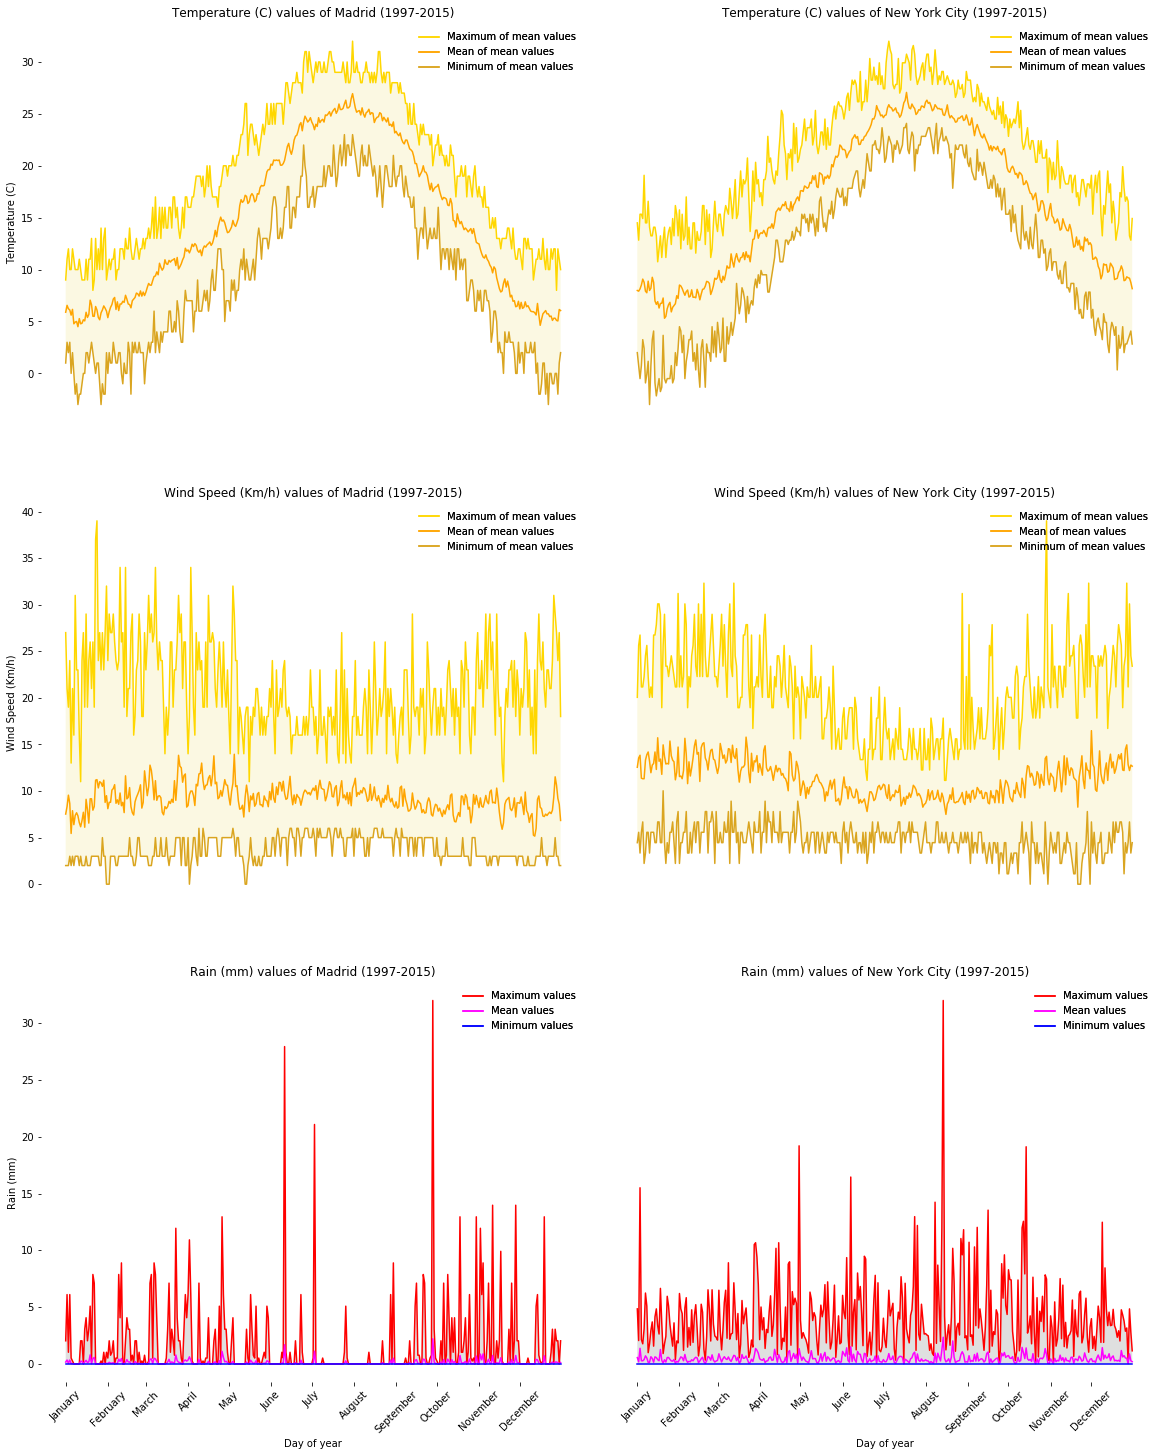

In [188]:
year_range = (1997, 2015)

#plt.figure(figsize=(20,25))

fig, ((ax1, ax2),(ax3, ax4),(ax5, ax6)) = plt.subplots(3, 2, sharex=True, sharey=False, figsize=(20,25))

#plt.subplot(3, 2, 1)
plot_temperature_by_day_of_year(madrid_df, city="Madrid", rolling_window=None, year_range=year_range, ax=ax1)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(True)

#plt.subplot(3, 2, 2)
plot_temperature_by_day_of_year(nyc_df, city="New York City", rolling_window=None, year_range=year_range, ax=ax2)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)

#plt.subplot(3, 2, 3)
plot_wind_speed_by_day_of_year(madrid_df, city="Madrid", rolling_window=None, year_range=year_range, ax=ax3)
ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(True)

#plt.subplot(3, 2, 4)
plot_wind_speed_by_day_of_year(nyc_df, city="New York City", rolling_window=None, year_range=year_range, ax=ax4)
ax4.xaxis.set_visible(False)
ax4.yaxis.set_visible(False)

#plt.subplot(3, 2, 5)
plot_precipitations_by_day_of_year(madrid_df, city="Madrid", rolling_window=None, year_range=year_range, ax=ax5)
ax5.xaxis.set_visible(True)
ax5.yaxis.set_visible(True)
for tick in ax5.get_xticklabels():
    tick.set_rotation(45)

#plt.subplot(3, 2, 6)
plot_precipitations_by_day_of_year(nyc_df, city="New York City", rolling_window=None, year_range=year_range, ax=ax6)
ax6.xaxis.set_visible(True)
ax6.yaxis.set_visible(False)
for tick in ax6.get_xticklabels():
    tick.set_rotation(45)

for ax_i in [ax1, ax2, ax3, ax4]:
    plt.setp(ax_i.get_xticklabels(), visible=False)

days_of_year = (
    ["01-{:02d}".format(i) for i in range(1,32)] +
    ["02-{:02d}".format(i) for i in range(1,29)] +
    ["03-{:02d}".format(i) for i in range(1,32)] +
    ["04-{:02d}".format(i) for i in range(1,31)] +
    ["05-{:02d}".format(i) for i in range(1,32)] +
    ["06-{:02d}".format(i) for i in range(1,31)] +
    ["07-{:02d}".format(i) for i in range(1,32)] +
    ["08-{:02d}".format(i) for i in range(1,32)] +
    ["09-{:02d}".format(i) for i in range(1,31)] +
    ["10-{:02d}".format(i) for i in range(1,32)] +
    ["11-{:02d}".format(i) for i in range(1,31)] +
    ["12-{:02d}".format(i) for i in range(1,32)]
)

month_positions = [days_of_year.index("{}-01".format(str(i).zfill(2))) for i in range(1,13)]

months = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December"
]
    
plt.xticks(
    month_positions,
    months,
    rotation=45
)

plt.subplots_adjust(hspace=0.2, wspace=0.05)
plt.show()

It seems that New York City is a bit colder than Madrid and above all, it rains a lot more.